# Real-word Trade-in Values of Car Brands

### Group members:

Jeewon Kim (261047040)

Jingyu Chen(261003560)

Yi Kuang(260951384)

Yingxin Jiang (261007353)

Yulin Hong (260898713)


## Import packages

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

## Scrapping latest 5000 posts and store in post_text

In [2]:
post_text=[]
for i in range(994,1095):
    url='https://forums.edmunds.com/discussion/1212/general/x/real-world-trade-in-values/p'+str(i)
    page=requests.get(url)
    page_text=page.text
    soup=BeautifulSoup(page_text, 'html.parser')
    post_text_elem= soup.find_all(class_="Message userContent")
    for item in post_text_elem:
        post_text.append(item.text.lstrip())
post_text = post_text[35:5035]


## Tokenize/remove stopwords/lemmatize

In [3]:
def tokenizer(words) -> list:
    tokenizer = RegexpTokenizer(r'[\w-]+')
    tokens = tokenizer.tokenize(words.lower())

    stopwords_set = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    return [lemmatizer.lemmatize(token, pos='v') for token in tokens if token not in stopwords_set]

#apply tokenizer function to each post, using set to remove the repeat and store in processed text
processed_text = []
for comment in post_text:
    processed_text.append(list(set(tokenizer(comment))))

## Import model_csv and process

In [4]:
model_grid = pd.read_csv('/Users/hong/Desktop/McGill/TEXT/models.csv')

model_grid['Brands'] = model_grid['Brands'].str.lower()
model_grid['model']  = model_grid['model'].str.lower()
model_grid = model_grid[['Brands','model']]

In [5]:
model_grid

,Brands,model
0,acura,cl
1,acura,ilx
2,acura,mdx
3,acura,nsx
4,acura,rdx
...,...,...
1642,maserati,gt coupe
1643,maserati,levante
1644,maserati,mc12
1645,maserati,quattroporte


## Calculate model frequency  

In [6]:
remove_dup = []
for comment in processed_text: 
    for i in range(len(comment)): 
        if comment[i] in model_grid.model.tolist():
            condition = model_grid['model'] == comment[i]
            brand_index = model_grid.index[condition].tolist()
            comment[i] = model_grid['Brands'].iloc[brand_index[0]]
    remove_dup.append(list(set(comment)))
fre = defaultdict(int)

In [7]:
for p in remove_dup:
    for w in p:
        if w in model_grid.Brands.tolist():
            fre[w] += 1

## Convert the brand frequency to dataframe and keep the top 10 brands

In [8]:
brand_frequency = dict(fre)
br = brand_frequency.keys()
fre = brand_frequency.values()
df = pd.DataFrame()
df['brand'] = br
df['frequency'] = fre

#include top 10 brand and its frequency
top = df.sort_values(by = 'frequency', ascending= False).head(10)

#top 10 brand
top

,brand,frequency
13,honda,378
7,chevrolet,280
16,toyota,274
9,ford,261
14,fiat,251
34,bmw,251
12,audi,234
32,volkswagen,220
1,subaru,193
15,nissan,191


In [9]:
top_10 = top.brand.tolist()

## Getting the combination of 10 brands to calculate the lift

In [10]:
from itertools import combinations
comb = list(combinations(top_10,2))

## Obtain a sub-dataframe to store the model for top10 brands

In [11]:
target_df = model_grid[model_grid['Brands'].isin(top_10)]
target_df = target_df.reset_index(drop = True)
target_df

,Brands,model
0,audi,a1
1,audi,a2
2,audi,a3
3,audi,a4
4,audi,a4 allroad
...,...,...
411,volkswagen,transporter shuttle
412,volkswagen,up!
413,volkswagen,vento
414,volkswagen,voyage


## Replace the model with its brand in the processed_text

In [12]:
for comment in processed_text: 
    for i in range(len(comment)): 
        if comment[i] in target_df.model.tolist():
            condition = target_df['model'] == comment[i]
            brand_index = target_df.index[condition].tolist()
            comment[i] = target_df['Brands'].iloc[brand_index[0]]

## Getting a narrowed list of the posts that contains brand

In [13]:
target_comment = []
for comment in processed_text:
    for words in comment:
        if words in top_10:
            target_comment.append(list(set(comment)))
#remove duplicate
target_comment_distinct = []
for i in target_comment:
    if i not in target_comment_distinct:
        target_comment_distinct.append(i)
        


## calculate the #(A,B) 

In [24]:
pair_frequency = {}
for i in comb:
    pair_frequency[i] = 0
for pair in comb:
    for comm in target_comment_distinct:
        if pair[0] in comm and pair[1] in comm:
            pair_frequency[pair] +=1

In [25]:
pair_frequency # #(AB)

{('honda', 'chevrolet'): 23,
 ('honda', 'toyota'): 27,
 ('honda', 'ford'): 33,
 ('honda', 'fiat'): 45,
 ('honda', 'bmw'): 18,
 ('honda', 'audi'): 22,
 ('honda', 'volkswagen'): 34,
 ('honda', 'subaru'): 26,
 ('honda', 'nissan'): 12,
 ('chevrolet', 'toyota'): 43,
 ('chevrolet', 'ford'): 38,
 ('chevrolet', 'fiat'): 26,
 ('chevrolet', 'bmw'): 15,
 ('chevrolet', 'audi'): 9,
 ('chevrolet', 'volkswagen'): 40,
 ('chevrolet', 'subaru'): 22,
 ('chevrolet', 'nissan'): 16,
 ('toyota', 'ford'): 21,
 ('toyota', 'fiat'): 25,
 ('toyota', 'bmw'): 15,
 ('toyota', 'audi'): 6,
 ('toyota', 'volkswagen'): 18,
 ('toyota', 'subaru'): 18,
 ('toyota', 'nissan'): 9,
 ('ford', 'fiat'): 16,
 ('ford', 'bmw'): 7,
 ('ford', 'audi'): 5,
 ('ford', 'volkswagen'): 20,
 ('ford', 'subaru'): 14,
 ('ford', 'nissan'): 11,
 ('fiat', 'bmw'): 23,
 ('fiat', 'audi'): 10,
 ('fiat', 'volkswagen'): 9,
 ('fiat', 'subaru'): 3,
 ('fiat', 'nissan'): 19,
 ('bmw', 'audi'): 11,
 ('bmw', 'volkswagen'): 7,
 ('bmw', 'subaru'): 5,
 ('bmw', 'nis

## Calculate lift

In [26]:
lift = defaultdict(int)
for i in pair_frequency.keys():
    lift[i] = (5000*pair_frequency[i]) / (brand_frequency[i[0]]*brand_frequency[i[1]])

In [27]:
for i in lift:
    if lift[i] == 0:
        lift[i] = 1

In [28]:
df_lifts = pd.DataFrame(columns=top_10,index=top_10)
for brand in top_10: 
    df_lifts[brand][brand] = '-'
for brands in lift:
    a,b = brands
    df_lifts[a][b] = (lift[brands])
    df_lifts[b][a] = '-'

In [29]:
df_lifts

,honda,chevrolet,toyota,ford,fiat,bmw,audi,volkswagen,subaru,nissan
honda,-,-,-,-,-,-,-,-,-,-
chevrolet,1.08655,-,-,-,-,-,-,-,-,-
toyota,1.30344,2.8024,-,-,-,-,-,-,-,-
ford,1.67244,2.59989,1.46824,-,-,-,-,-,-,-
fiat,2.37147,1.84974,1.81755,1.22117,-,-,-,-,-,-
bmw,0.948587,1.06716,1.09053,0.534261,1.82537,-,-,-,-,-
audi,1.24361,0.686813,0.467902,0.409339,0.851296,0.936425,-,-,-,-
volkswagen,2.04425,3.24675,1.49303,1.74155,0.814922,0.633828,2.52525,-,-,-
subaru,1.78194,2.03553,1.7019,1.38963,0.309642,0.51607,1.54998,1.17758,-,-
nissan,0.831048,1.49589,0.859862,1.10329,1.9816,1.14724,1,0.475964,2.71275,-


In [30]:
top_brand_lifts = pd.DataFrame(columns=top_10,index=top_10)
for brands in lift:
    a,b = brands
    top_brand_lifts[a][b] = (1/lift[brands])
    top_brand_lifts[b][a] = (1/lift[brands])
for brand in top_10: 
    top_brand_lifts[brand][brand] = 0

In [31]:
top_brand_lifts

,honda,chevrolet,toyota,ford,fiat,bmw,audi,volkswagen,subaru,nissan
honda,0,0.920348,0.7672,0.597927,0.42168,1.0542,0.804109,0.489176,0.561185,1.2033
chevrolet,0.920348,0,0.356837,0.384632,0.540615,0.937067,1.456,0.308,0.491273,0.6685
toyota,0.7672,0.356837,0,0.681086,0.550192,0.916987,2.1372,0.669778,0.587578,1.16298
ford,0.597927,0.384632,0.681086,0,0.818887,1.87174,2.44296,0.5742,0.719614,0.906382
fiat,0.42168,0.540615,0.550192,0.818887,0,0.547835,1.17468,1.22711,3.22953,0.504642
bmw,1.0542,0.937067,0.916987,1.87174,0.547835,0,1.06789,1.57771,1.93772,0.871655
audi,0.804109,1.456,2.1372,2.44296,1.17468,1.06789,0,0.396,0.645171,1
volkswagen,0.489176,0.308,0.669778,0.5742,1.22711,1.57771,0.396,0,0.8492,2.101
subaru,0.561185,0.491273,0.587578,0.719614,3.22953,1.93772,0.645171,0.8492,0,0.36863
nissan,1.2033,0.6685,1.16298,0.906382,0.504642,0.871655,1,2.101,0.36863,0


In [38]:
from sklearn import manifold
import matplotlib.pyplot as plt
mds = manifold.MDS(dissimilarity='euclidean',random_state=522)
mds_fit = mds.fit(top_brand_lifts)
coords = mds.fit_transform(top_brand_lifts)

/Users/hong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"
/Users/hong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


Text(0.5, 1.0, 'Multidimensional Scaling: Top 10 Brands \n (Euclidean Distances = 1 / lift)')

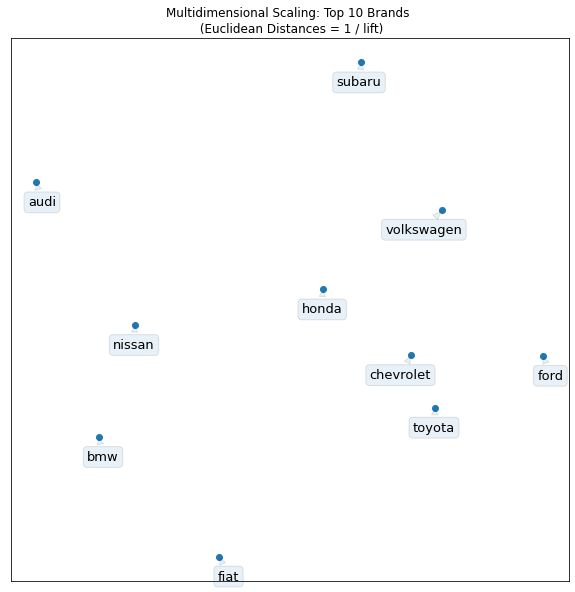

In [39]:
x,y = coords.T

plt.figure(figsize=(10, 10))
plt.scatter(x,y)

for i, txt in enumerate(top_10):
    plt.annotate(txt, (x[i], y[i]), xycoords='data',
             xytext=(20, -20), textcoords='offset points',
             size=13, ha='right', va="center",
             bbox=dict(boxstyle="round", alpha=0.1),
             arrowprops=dict(arrowstyle="wedge,tail_width=0.5", alpha=0.1))
    
plt.yticks([])
plt.xticks([])
plt.title('Multidimensional Scaling: Top 10 Brands \n (Euclidean Distances = 1 / lift)')

## Analyze most frequently mentioned attributes of cars in the discussions

To calculate the most frequently mentioned attributes of cars in the discussions, we then look for the attributes from the narrowed list of the posts that contains brand (which we got in Task A).
But rather than using this list directly, we remove the verbs, conjunctions and prepositions first.

### Tagging words in target comment

In [40]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /Users/hong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hong/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [41]:
wordlist = []
for i in range(len(target_comment)):
    for j in range(len(target_comment[i])):
        wordlist.append(target_comment[i][j])
text = ' '.join(wordlist).lower()

In [42]:
tokens = nltk.word_tokenize(text)

In [43]:
tags = nltk.pos_tag(tokens)

In [44]:
n_adj_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS' 
                                             or pos == 'VBD' or pos == 'JJ' or pos == 'JJR' or pos == 'JJS'
                                             or pos =='RB' or pos =='RBR'or pos =='RBS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]

Firstly we did a word cloud based on the noun and adjs in the selecteed posts, to have a brief idea of attributes

In [45]:
n_adj_string=(" ").join(n_adj_list)
adj_string=(" ").join(adj_list)

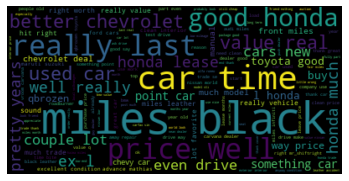

In [46]:
wordcloud1 = WordCloud().generate(n_adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

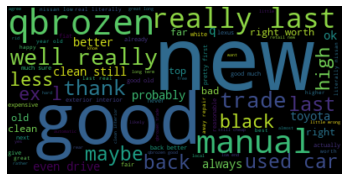

In [47]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Calculate the frequency of words and organized the most frequently mentioned word into it's related car attribute

To calculate the most frequently mentioned attributes of cars in the discussions, we then look for frequency of each words in the n_adj_list. And manually assign those words into attributes in csv


In [48]:
#count the words frequency and sort
from collections import Counter
counts = Counter(n_adj_list)


Based on the counts generated above, we then manually store these information into attributes.csv, categorized them into each attribute.

The result is in the following csv file:

In [49]:
#import attributes csv
attributes = pd.read_csv('/Users/hong/Desktop/McGill/TEXT/attributes.csv')


In [50]:
attributes.head()

,range,range_f,performance,performance_f,comfort,comfort_f,vehicle_architecture,vehicle_architecture_f,safety,safety_f,...,interior_sound,interior_sound_f,thermal_management,thermal_management_f,energy_management,energy_management_f,appearance,appearance_f,cost_efficiency,cost_efficiency_f
0,last,198.0,manual,125.0,leather,93.0,year,276,accident,110.0,...,interior,161.0,oil,51.0,power,52.0,new,505,trade,408.0
1,months,146.0,pick,50.0,vroom,80.0,condition,246,repair,109.0,...,radio,21.0,hybrid,29.0,gas,35.0,look,470,dealer,418.0
2,road,59.0,heat,49.0,small,60.0,model,159,damage,89.0,...,noise,14.0,equipment,19.0,equipment,19.0,black,234,value,470.0
3,speed,56.0,quick,49.0,sit,51.0,seat,133,accidents,72.0,...,speakers,11.0,electrical,18.0,electrical,18.0,old,188,pay,260.0
4,hour,20.0,roadburner,42.0,size,49.0,engine,126,reliable,36.0,...,NaN,NaN,radiator,18.0,battery,13.0,blue,139,cheap,64.0


In [51]:
s = attributes[['range_f', 'performance_f', 'comfort_f', 'vehicle_architecture_f','safety_f', 'drivability_f', 'interior_sound_f', 'thermal_management_f', 'energy_management_f', 'appearance_f','cost_efficiency_f']].sum()

In [52]:
##get the most frequently mentioned 5 attributes
attr = s.sort_values(ascending=False)
attr = pd.DataFrame({'attributes':attr.index, 'frequency':attr.values})
attr

,attributes,frequency
0,cost_efficiency_f,2312.0
1,appearance_f,2026.0
2,drivability_f,1447.0
3,vehicle_architecture_f,1287.0
4,range_f,545.0
5,safety_f,485.0
6,comfort_f,481.0
7,performance_f,394.0
8,interior_sound_f,207.0
9,energy_management_f,162.0


### Top 5 car brands' frequency and lift for attributes that mentioned in the discussion

In [53]:
##From TASK A we get the most frequently mentioned brands are:
top5 = df.sort_values(by = 'frequency', ascending= False).head(5)
top5

,brand,frequency
13,honda,378
7,chevrolet,280
16,toyota,274
9,ford,261
14,fiat,251


In [54]:
import itertools
attlist = []
brandlist = []
for i in attr['attributes']:
    attlist.append(i)
    
for i in top5['brand']:
    brandlist.append(i) 

all_combinations = list(itertools.product(brandlist, attlist))


In [55]:
com = []
for i in range(len(all_combinations)):
    com.append(all_combinations[i])

#to remove duplicated combinations
com = list(set(com))

To calculate which attributes are most strongly associated with which of these 5 brands?

Calculate the #(Brand, attribute)

In [56]:
import copy
comment_copy = copy.deepcopy(target_comment)

In [57]:
#to replace each specific words with attributes in the text

for j in range(len(target_comment)):
    for i in range(len(target_comment[j])):
        if target_comment[j][i] in attributes.cost_efficiency.dropna().tolist():
            target_comment[j][i] = 'cost_efficiency_f'
            continue
        if target_comment[j][i] in attributes.appearance.dropna().tolist():
            target_comment[j][i] = 'appearance_f'
            continue
        if target_comment[j][i] in attributes.drivability.dropna().tolist():
            target_comment[j][i] = 'drivability_f'
            continue
        if target_comment[j][i] in attributes.range.dropna().tolist():
            target_comment[j][i] = 'range_f'
            continue
        if target_comment[j][i] in attributes.vehicle_architecture.dropna().tolist():
            target_comment[j][i] = 'vehicle_architecture_f'
            continue
        if target_comment[j][i] in attributes.performance.dropna().tolist():
            target_comment[j][i] = 'performance_f'
            continue
        if target_comment[j][i] in attributes.comfort.dropna().tolist():
            target_comment[j][i] = 'comfort_f'
            continue
        if target_comment[j][i] in attributes.safety.dropna().tolist():
            target_comment[j][i] = 'safety_f'
            continue
        if target_comment[j][i] in attributes['interior_sound'].tolist():
            target_comment[j][i] = 'interior_sound_f'
            continue
        if target_comment[j][i] in attributes.thermal_management.dropna().tolist():
            target_comment[j][i] = 'thermal_managemen_f'
            continue
        if target_comment[j][i] in attributes.energy_management.dropna().tolist():
            target_comment[j][i] = 'energy_management_f'
            continue

In [58]:
pair_f = defaultdict(int)
for pair in com:

    for comment in target_comment:
        if pair[0] in comment and pair[1] in comment:

            pair_f[pair] +=1


In [59]:
brand_dict = {}
for (key, value) in brand_frequency.items():
    if key in top5.brand.tolist():
        brand_dict[key] = value
att_dict = dict(zip(attr.attributes, attr.frequency))
att_dict

{'cost_efficiency_f': 2312.0,
 'appearance_f': 2026.0,
 'drivability_f': 1447.0,
 'vehicle_architecture_f': 1287.0,
 'range_f': 545.0,
 'safety_f': 485.0,
 'comfort_f': 481.0,
 'performance_f': 394.0,
 'interior_sound_f': 207.0,
 'energy_management_f': 162.0,
 'thermal_management_f': 148.0}

In [60]:
#Calculate Lift
liftC = defaultdict(int)
for i in pair_f.keys():
    
    liftC[i] = (5000*pair_f[i]) / (brand_dict[i[0]]*att_dict[i[1]])

### Create dataframe for each brand

In [61]:
honda_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'honda':
        honda_attr_lift = honda_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

In [62]:
honda_attr_lift = honda_attr_lift.sort_values(by = 'Lift', ascending= False)

In [63]:
honda_attr_lift

,attribute,Lift
1,comfort_f,6.545007
5,interior_sound_f,6.070598
0,range_f,5.388088
6,drivability_f,5.055159
2,performance_f,4.767276
4,energy_management_f,4.735776
9,safety_f,4.554628
3,vehicle_architecture_f,3.864448
8,appearance_f,3.695347
7,cost_efficiency_f,3.255387


In [64]:
chevrolet_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'chevrolet':
        chevrolet_attr_lift = chevrolet_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

chevrolet_attr_lift = chevrolet_attr_lift.sort_values(by = 'Lift', ascending= False)

In [65]:
chevrolet_attr_lift

,attribute,Lift
2,range_f,6.815203
3,performance_f,6.390500
5,energy_management_f,4.960317
8,drivability_f,4.726528
4,comfort_f,4.566380
6,vehicle_architecture_f,4.218004
0,appearance_f,3.842899
1,safety_f,3.792342
7,interior_sound_f,3.278123
9,cost_efficiency_f,3.228497


In [66]:
toyota_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'toyota':
        toyota_attr_lift = toyota_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

toyota_attr_lift = toyota_attr_lift.sort_values(by = 'Lift', ascending= False)

In [67]:
toyota_attr_lift

,attribute,Lift
3,comfort_f,7.322033
0,safety_f,5.907141
1,range_f,5.725574
2,performance_f,5.511505
6,interior_sound_f,5.465637
7,drivability_f,5.246193
4,vehicle_architecture_f,4.111865
9,appearance_f,3.909037
5,energy_management_f,3.604578
8,cost_efficiency_f,3.354444


In [68]:
ford_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'ford':
        ford_attr_lift = ford_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

ford_attr_lift = ford_attr_lift.sort_values(by = 'Lift', ascending= False)

In [69]:
ford_attr_lift

,attribute,Lift
9,performance_f,7.487796
2,interior_sound_f,7.218613
8,comfort_f,7.129145
0,energy_management_f,6.858711
7,range_f,6.784070
3,drivability_f,5.097083
1,vehicle_architecture_f,4.807878
5,appearance_f,3.659325
4,cost_efficiency_f,3.380663
6,safety_f,3.001935


In [70]:
fiat_attr_lift = pd.DataFrame(columns=["attribute","Lift"])
for i in liftC.keys():
    if i[0] == 'fiat':
        fiat_attr_lift = fiat_attr_lift.append({'attribute': i[1], 'Lift': liftC[i]}, ignore_index=True)

fiat_attr_lift = fiat_attr_lift.sort_values(by = 'Lift', ascending= False)

In [71]:
fiat_attr_lift

,attribute,Lift
1,performance_f,6.319898
2,comfort_f,5.590942
0,range_f,4.532329
6,drivability_f,4.350256
3,vehicle_architecture_f,3.219445
5,interior_sound_f,2.983236
8,appearance_f,2.949702
7,cost_efficiency_f,2.593432
4,energy_management_f,2.336334
9,safety_f,2.300078


## Analyze attribute detail of top 5 brand

Conduct anlysis on each top 5 brand to provide advice to a product manager, and marketing/advertising
manager.

In [72]:
detial_attributes = pd.read_csv('/Users/hong/Desktop/McGill/TEXT/detail_attribute.csv')

In [73]:
detial_attributes = detial_attributes.detail_attribute.values

#### Honda

In [74]:
honda_comment = []
for comment in comment_copy:
    if 'honda' in comment:
        honda_comment.append(list(set(comment)))


In [75]:
honda_attr = defaultdict(int)
for comment in honda_comment:
    for attr in detial_attributes:
        if attr in comment:

            honda_attr[attr] +=1


In [76]:
honda_attr = pd.DataFrame(list(zip(honda_attr.keys(), honda_attr.values())),columns =['attribute', 'frequency'])
honda_attr = honda_attr.sort_values(by = 'frequency', ascending= False)

In [77]:
honda_attr.head(10)

,attribute,frequency
6,new,210
16,condition,141
1,black,120
5,deal,118
14,old,104
18,lease,94
20,mileage,91
30,seat,82
4,interior,82
37,engine,67


Honda performance related comment visualization:

In [78]:
honda_performance_comment = []
for j in range(len(honda_comment)):
    for i in range(len(honda_comment[j])):
        if honda_comment[j][i] in attributes.performance.dropna().tolist():
            honda_performance_comment.append(list(set(honda_comment[j])))

In [79]:
honda_performance_list = []
for i in range(len(honda_performance_comment)):
    for j in range(len(honda_performance_comment[i])):
        honda_performance_list.append(honda_performance_comment[i][j])
text = ' '.join(honda_performance_list).lower()
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

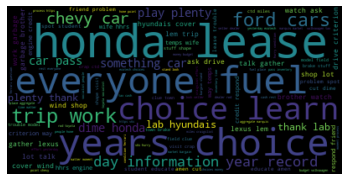

In [80]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

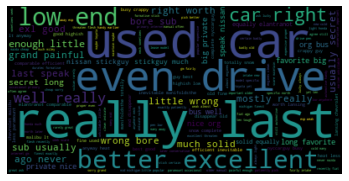

In [81]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Honda energy_management related comment visualization:

In [82]:
honda_energy_management_comment = []
for j in range(len(honda_comment)):
    for i in range(len(honda_comment[j])):
        if honda_comment[j][i] in attributes.energy_management.dropna().tolist():
            honda_energy_management_comment.append(list(set(honda_comment[j])))

In [83]:
honda_energy_management_list = []
for i in range(len(honda_energy_management_comment)):
    for j in range(len(honda_energy_management_comment[i])):
        honda_energy_management_list.append(honda_energy_management_comment[i][j])
text = ' '.join(honda_energy_management_list).lower()
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

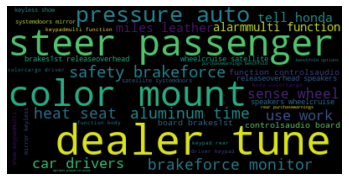

In [84]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

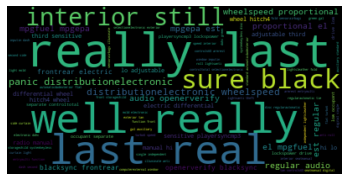

In [85]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Honda comfort related comment visualization:

In [86]:
honda_comfort_comment = []
for j in range(len(honda_comment)):
    for i in range(len(honda_comment[j])):
        if honda_comment[j][i] in attributes.comfort.dropna().tolist():
            honda_comfort_comment.append(list(set(honda_comment[j])))

In [87]:
honda_comfort_list = []
for i in range(len(honda_comfort_comment)):
    for j in range(len(honda_comfort_comment[i])):
        honda_comfort_list.append(honda_comfort_comment[i][j])
text = ' '.join(honda_comfort_list).lower()
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

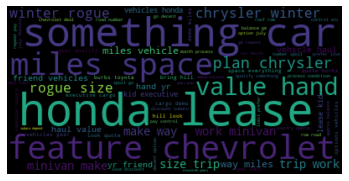

In [88]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

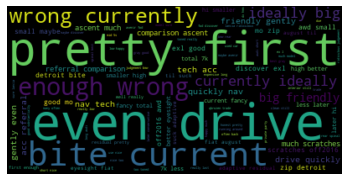

In [89]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Chevrolet

In [90]:
chevrolet_comment = []
for comment in comment_copy:
    if 'chevrolet' in comment:
        chevrolet_comment.append(list(set(comment)))

In [91]:
chevrolet_attr = defaultdict(int)
for comment in chevrolet_comment:
    for attr in detial_attributes:
        if attr in comment:

            chevrolet_attr[attr] +=1
chevrolet_attr = pd.DataFrame(list(zip(chevrolet_attr.keys(), chevrolet_attr.values())),columns =['attribute', 'frequency'])
chevrolet_attr = chevrolet_attr.sort_values(by = 'frequency', ascending= False)

In [92]:
chevrolet_attr.head(10)

,attribute,frequency
6,new,150
9,old,135
15,condition,117
7,lease,94
5,deal,85
33,black,77
32,engine,70
12,repair,53
3,seat,48
36,cheap,48


Chevrolet safety related comment visualization:

In [93]:
chevrolet_safety_comment = []
for j in range(len(chevrolet_comment)):
    for i in range(len(chevrolet_comment[j])):
        if chevrolet_comment[j][i] in attributes.safety.dropna().tolist():
            chevrolet_safety_comment.append(list(set(chevrolet_comment[j])))

In [94]:
chevrolet_safety_list = []
for i in range(len(chevrolet_safety_comment)):
    for j in range(len(chevrolet_safety_comment[i])):
        chevrolet_safety_list.append(chevrolet_safety_comment[i][j])
text = ' '.join(chevrolet_safety_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

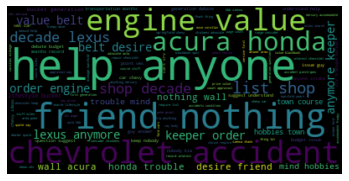

In [95]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

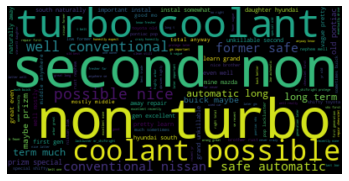

In [96]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Chevrolet interial related comment visualization:

In [97]:
chevrolet_interior_sound_comment = []
for j in range(len(chevrolet_comment)):
    for i in range(len(chevrolet_comment[j])):
        if chevrolet_comment[j][i] in attributes.interior_sound.dropna().tolist():
            chevrolet_interior_sound_comment.append(list(set(chevrolet_comment[j])))

In [98]:
chevrolet_interior_sound_list = []
for i in range(len(chevrolet_interior_sound_comment)):
    for j in range(len(chevrolet_interior_sound_comment[i])):
        chevrolet_interior_sound_list.append(chevrolet_interior_sound_comment[i][j])
text = ' '.join(chevrolet_interior_sound_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

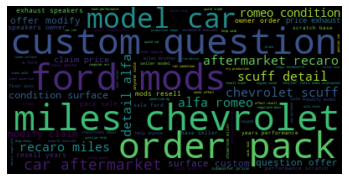

In [99]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

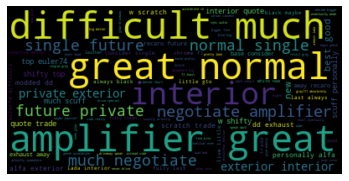

In [100]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Chevrolet performance related comment visualization:

In [101]:
chevrolet_performance_comment = []
for j in range(len(chevrolet_comment)):
    for i in range(len(chevrolet_comment[j])):
        if chevrolet_comment[j][i] in attributes.performance.dropna().tolist():
            chevrolet_performance_comment.append(list(set(chevrolet_comment[j])))

In [102]:
chevrolet_performance_list = []
for i in range(len(chevrolet_performance_comment)):
    for j in range(len(chevrolet_performance_comment[i])):
        chevrolet_performance_list.append(chevrolet_performance_comment[i][j])
text = ' '.join(chevrolet_performance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

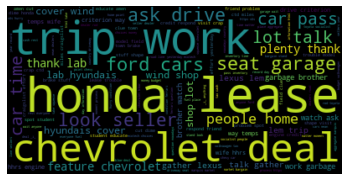

In [103]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

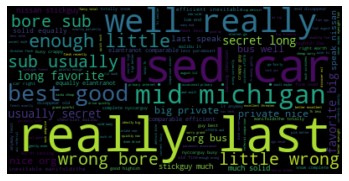

In [104]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Toyota

In [105]:
toyota_comment = []
for comment in comment_copy:
    if 'toyota' in comment:
        toyota_comment.append(list(set(comment)))

In [106]:
toyota_attr = defaultdict(int)
for comment in toyota_comment:
    for attr in detial_attributes:
        if attr in comment:

            toyota_attr[attr] +=1
toyota_attr = pd.DataFrame(list(zip(toyota_attr.keys(), toyota_attr.values())),columns =['attribute', 'frequency'])
toyota_attr = toyota_attr.sort_values(by = 'frequency', ascending= False)

In [107]:
toyota_attr.head(10)

,attribute,frequency
3,new,112
0,condition,107
9,old,104
36,lease,97
5,deal,82
50,repair,72
30,engine,68
38,black,64
10,leather,60
18,cheap,56


Toyota performance related comment visualization:

In [108]:
toyota_performance_comment = []
for j in range(len(toyota_comment)):
    for i in range(len(toyota_comment[j])):
        if toyota_comment[j][i] in attributes.performance.dropna().tolist():
            toyota_performance_comment.append(list(set(toyota_comment[j])))

In [109]:
toyota_performance_list = []
for i in range(len(toyota_performance_comment)):
    for j in range(len(toyota_performance_comment[i])):
        toyota_performance_list.append(toyota_performance_comment[i][j])
text = ' '.join(toyota_performance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

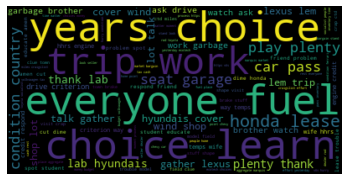

In [110]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

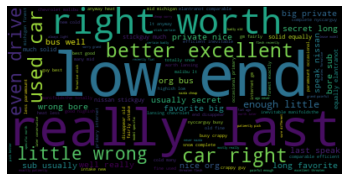

In [111]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Toyota energy_management related comment visualization:

In [112]:
toyota_energy_management_comment = []
for j in range(len(toyota_comment)):
    for i in range(len(toyota_comment[j])):
        if toyota_comment[j][i] in attributes.energy_management.dropna().tolist():
            toyota_energy_management_comment.append(list(set(toyota_comment[j])))

In [113]:
toyota_energy_management_list = []
for i in range(len(toyota_energy_management_comment)):
    for j in range(len(toyota_energy_management_comment[i])):
        toyota_energy_management_list.append(toyota_energy_management_comment[i][j])
text = ' '.join(toyota_energy_management_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

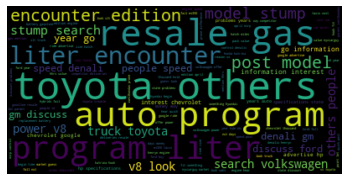

In [114]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

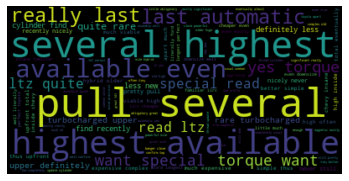

In [115]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Toyota comfort related comment visualization:

In [116]:
toyota_comfort_comment = []
for j in range(len(toyota_comment)):
    for i in range(len(toyota_comment[j])):
        if toyota_comment[j][i] in attributes.comfort.dropna().tolist():
            toyota_comfort_comment.append(list(set(toyota_comment[j])))

In [117]:
toyota_comfort_list = []
for i in range(len(toyota_comfort_comment)):
    for j in range(len(toyota_comfort_comment[i])):
        toyota_comfort_list.append(toyota_comfort_comment[i][j])
text = ' '.join(toyota_comfort_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

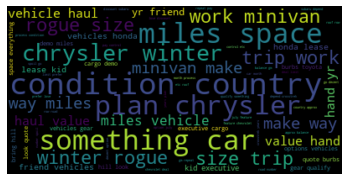

In [118]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

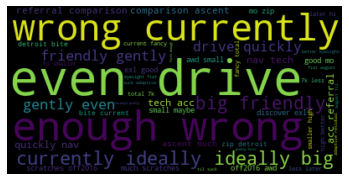

In [119]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Ford

In [120]:
ford_comment = []
for comment in comment_copy:
    if 'ford' in comment:
        ford_comment.append(list(set(comment)))

In [121]:
ford_attr = defaultdict(int)
for comment in ford_comment:
    for attr in detial_attributes:
        if attr in comment:

            ford_attr[attr] +=1
ford_attr = pd.DataFrame(list(zip(ford_attr.keys(), ford_attr.values())),columns =['attribute', 'frequency'])
ford_attr = ford_attr.sort_values(by = 'frequency', ascending= False)

In [122]:
ford_attr.head(10)

,attribute,frequency
9,new,153
14,condition,106
10,deal,95
1,seat,91
5,wheel,88
36,old,82
29,engine,76
12,leather,72
15,interior,69
20,manual,58


Ford safety related comment visualization:

In [123]:
ford_safety_comment = []
for j in range(len(ford_comment)):
    for i in range(len(ford_comment[j])):
        if ford_comment[j][i] in attributes.safety.dropna().tolist():
            ford_safety_comment.append(list(set(ford_comment[j])))

In [124]:
ford_safety_list = []
for i in range(len(ford_safety_comment)):
    for j in range(len(ford_safety_comment[i])):
        ford_safety_list.append(ford_safety_comment[i][j])
text = ' '.join(ford_safety_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

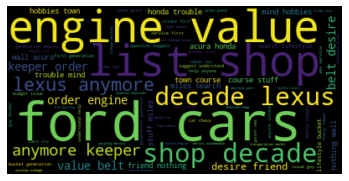

In [125]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

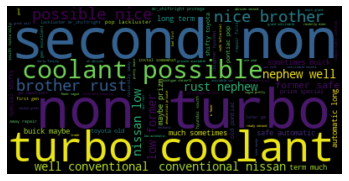

In [126]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Ford appearance related comment visualization:

In [127]:
ford_appearance_comment = []
for j in range(len(ford_comment)):
    for i in range(len(ford_comment[j])):
        if ford_comment[j][i] in attributes.appearance.dropna().tolist():
            ford_appearance_comment.append(list(set(ford_comment[j])))

In [128]:
ford_appearance_list = []
for i in range(len(ford_appearance_comment)):
    for j in range(len(ford_appearance_comment[i])):
        ford_appearance_list.append(ford_appearance_comment[i][j])
text = ' '.join(ford_appearance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

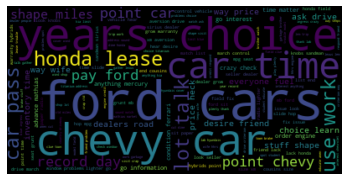

In [129]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

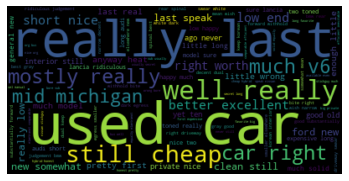

In [130]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Ford performance related comment visualization:

In [131]:
ford_peformance_comment = []
for j in range(len(ford_comment)):
    for i in range(len(ford_comment[j])):
        if ford_comment[j][i] in attributes.appearance.dropna().tolist():
            ford_peformance_comment.append(list(set(ford_comment[j])))

In [132]:
ford_performance_list = []
for i in range(len(ford_peformance_comment)):
    for j in range(len(ford_peformance_comment[i])):
        ford_performance_list.append(ford_peformance_comment[i][j])
text = ' '.join(ford_performance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

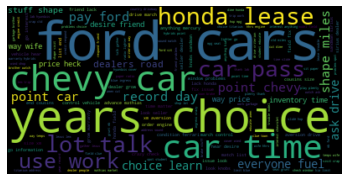

In [133]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

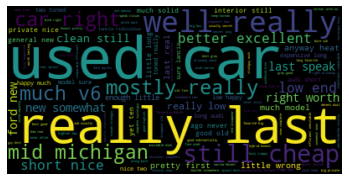

In [134]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Fiat

In [135]:
fiat_comment = []
for comment in comment_copy:
    if 'fiat' in comment:
        fiat_comment.append(list(set(comment)))

In [136]:
fiat_attr = defaultdict(int)
for comment in fiat_comment:
    for attr in detial_attributes:
        if attr in comment:

            fiat_attr[attr] +=1
fiat_attr = pd.DataFrame(list(zip(fiat_attr.keys(), fiat_attr.values())),columns =['attribute', 'frequency'])
fiat_attr = fiat_attr.sort_values(by = 'frequency', ascending= False)

In [137]:
fiat_attr.head(10)

,attribute,frequency
18,new,84
10,condition,73
5,deal,57
1,black,56
55,old,54
35,lease,52
0,leather,45
9,manual,44
11,mileage,44
31,seat,42


Fiat safety related comment visualization:

In [138]:
fiat_safety_comment = []
for j in range(len(fiat_comment)):
    for i in range(len(fiat_comment[j])):
        if fiat_comment[j][i] in attributes.safety.dropna().tolist():
            fiat_safety_comment.append(list(set(fiat_comment[j])))

In [139]:
fiat_safety_list = []
for i in range(len(fiat_safety_comment)):
    for j in range(len(fiat_safety_comment[i])):
        fiat_safety_list.append(fiat_safety_comment[i][j])
text = ' '.join(fiat_safety_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

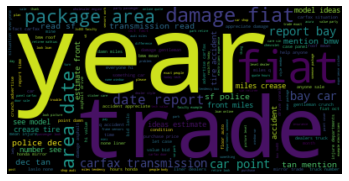

In [140]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

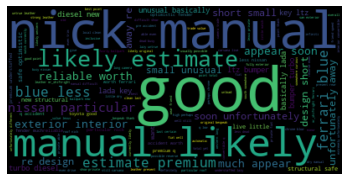

In [141]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Fiat energy_management related comment visualization:

In [142]:
fiat_energy_management_comment = []
for j in range(len(fiat_comment)):
    for i in range(len(fiat_comment[j])):
        if fiat_comment[j][i] in attributes.energy_management.dropna().tolist():
            fiat_energy_management_comment.append(list(set(fiat_comment[j])))

In [143]:
fiat_energy_management_list = []
for i in range(len(fiat_energy_management_comment)):
    for j in range(len(fiat_energy_management_comment[i])):
        fiat_energy_management_list.append(fiat_energy_management_comment[i][j])
text = ' '.join(fiat_energy_management_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

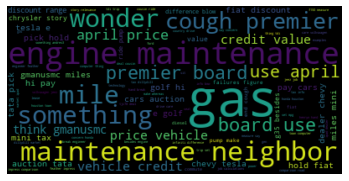

In [144]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

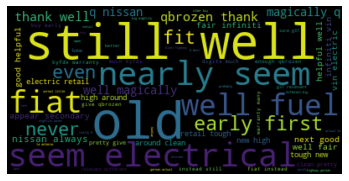

In [145]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

Fiat performance related comment visualization:

In [146]:
fiat_performance_comment = []
for j in range(len(fiat_comment)):
    for i in range(len(fiat_comment[j])):
        if fiat_comment[j][i] in attributes.performance.dropna().tolist():
            fiat_performance_comment.append(list(set(fiat_comment[j])))

In [147]:
fiat_performance_list = []
for i in range(len(fiat_performance_comment)):
    for j in range(len(fiat_performance_comment[i])):
        fiat_performance_list.append(fiat_performance_comment[i][j])
text = ' '.join(fiat_performance_list).lower()

tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
n_list = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]

adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]
n_string=(" ").join(n_list)
adj_string=(" ").join(adj_list)

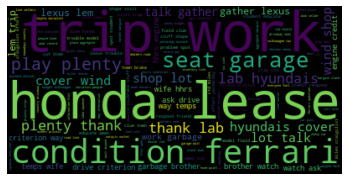

In [148]:
wordcloud1 = WordCloud().generate(n_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

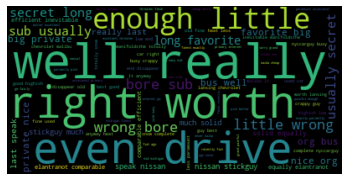

In [149]:
wordcloud1 = WordCloud().generate(adj_string)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

## Discover the most aspirational brand in the discussion

Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. (For task E, provide all details of your analysis – e.g., how you measured "aspirational" and how you found the most aspirational brand.)

The definition of the aspirational brand found from literature search:

The aspirational brand means which brand:

    1) People want to own, but not already owned for now
    2) And the motivation of wants should be related to the brand's emotional value.
    3) It should be achievable (to delineate the concept from just 'luxurious' brands)

But the third definition can not be described from the current dataset; in field research, the survey method is usually utilized to distinguish an aspirational brand from a luxury brand. (reference: I've Wanted A BMW Since I Was A Kid: An Exploratory Analysis Of The Aspirational Brand, 2015, The Journal of Applied Business Research) Therefore, I decided to focus on finding the set of terms that can serve the definition no.1 and no.2. 


Methodology (Steps)

* to define 'aspirational words' in the given dataset

    * scope to 'adj' words using nltk tagging
    * using VADER, gauge positive score of each word
    * filter only with positivity score is greater than 0.5
    * manually delete irrelevant words from positive word set
    * manually delete functional positivity words from positive word set
        * positive word set consists of 'functional positivity (including 'value for money" and 'emotional positivity' - I decided to keep only 'emotional' part.
    
* With the derived aspirational list of words, calculate lift value for the top 10 brands.
   * only keep rows whose lift value is greater than 1 
* From the lift scores, calculate 'average lift' with aspirational terms per brand.
* The brand shows the highest mean of lifts among aspirational terms is the most aspirational brand.

In [150]:
wordlist = []
for i in range(len(target_comment)):
    for j in range(len(target_comment[i])):
        wordlist.append(target_comment[i][j])
text = ' '.join(wordlist).lower()

In [151]:
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
adj_list = [word for word, pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos =='RB' or pos =='RBR'
                                          or pos =='RBS')]

### Define aspiration word set

In [152]:
#using VADER, gauge positive score of each word 
#and narrow down the words of interest with positivity score is greater than 0.5

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer() 
#sent.polarity_scores('like')

pos_word_dict = {} 
for i in adj_list: #adj_list
    if sent.polarity_scores(i)['pos'] > 0.5:  #filter with positivity score > 0.5
        pos_word_dict[i] = sent.polarity_scores(i)['pos']
        #print(i, sent.polarity_scores(i), sent.polarity_scores(i)['pos'])
    
#pos_word_dict

In [153]:
pos_list = list(pos_word_dict.keys())

In [154]:
#eliminate irrelevant words from pos_list
irr_list = ['ha','thanks-', 'well-', 'yay','hug','pray', 'truer','fiestas','gl','fresh', 'bless','smile', 'admit', 'sure', 'highlight','grant','forgiveness', 'agree', 'forgive', 'popular','thank', 'generous', 'clear', 'silly', 'curious', 'certainly', 'welcome', 'yeah', 'peculiar', 'definitely', 'luckily', 'honest', 'nicely', 'certain', 'straight', 'ok', 'honesty', 'create', 'please', 'win', 'grey', 'true', 'honestly', 'convince', 'ready', 'thankfully', 'dear', 'kiss', 'gently', 'yes', 'truly', 'extend', 'strongly', 'hopefully', 'carefully', 'important', 'matter', 'friendly', 'tx', 'tia', 'substantial', 'courtesy', 'clearly', 'respectively', 'greater', 'allow', 'join', 'humorous', 'treat', 'definite', 'funny', 'friend', 'greet', 'optimistically', 'gla', 'agreeable', 'invite', 'lol', 'surprise', 'sigh', 'apologize', 'excuse', 'ly', 'sunny', 'god', 'acceptable', 'okay', 'yep', 'casually', 'ftw', 'alert', 'hilarious', 'accept', 'sincerely', 'importantly', 'respectfully', 'nh', 'laugh', 'goodness', 'reach', 'positively', 'resolve', 'luckier', 'natural', 'fyi', 'thx', 'friends', 'surprisingly', 'truthfully', 'surely', 'truth', 'relieve', 'haha']
pos_list = [item for item in pos_list if item not in irr_list]

#eliminate functional positivity related words
func_list = ['prevent','support','adopt','clean','solve','tolerance','incentive', 'huge', 'helpful', 'easily', 'comfortable','scoop', 'profitable', 'protect', 'defensive', 'careful', 'easier', 'fit', 'smart', 'gt', 'freeway', 'care', 'easy', 'recommend', 'safe', 'casual', 'solid', 'save', 'responsible', 'useful', 'efficient', 'benefit', 'legal', 'stealthily', 'effectively', 'improve', 'reward', 'capable', 'healthy', 'effective', 'stable', 'powerful', 'easiest', 'comprehensive', 'warm', 'help', 'safely', 'faithful', 'incentives', 'painless', 'cleaner', 'mandatory']
pos_list = [item for item in pos_list if item not in func_list]

In [155]:
aspirations = pos_list

In [156]:
len(aspirations)

126

### Calculate lift value for the combination of aspiration terms and the top 10 brands

In [157]:
#Make combination of Top 10 Brand and aspirations
import itertools
comb = list(itertools.product(top_10,aspirations))

In [158]:
# Calculate Brand frequency
brand_dict = {}
for (key, value) in brand_frequency.items():
    if key in top_10:
        brand_dict[key] = value

In [159]:
# Calculate aspirational words' mentioned frequency
asp_frequency = defaultdict(int)
for comment in processed_text: 
    for words in comment: 
        if words in aspirations:
            asp_frequency[words]+=1

#asp_frequency

In [160]:
# Calculate the #(A,B); pair frequency
pair_frequency = defaultdict(int)
for pair in comb:
    for comm in target_comment_distinct:
        if pair[0] in comm and pair[1] in comm:
            pair_frequency[pair] +=1

In [161]:
#calculate 'liftA'; lift values for aspirations - brands
liftA = {}
for i in pair_frequency.keys():
    #print(pair_frequency[i], brand_dict[i[0]], asp_frequency[i[1]])
    liftA[i] = i[0], (5000*pair_frequency[i]) / (brand_dict[i[0]]*asp_frequency[i[1]])

In [162]:
#only keep rows whose lift value > 1 
df_A = pd.DataFrame.from_dict(liftA, orient='index', columns=['brand','lift'])
df_A.sort_values(ascending = True, by = 'lift').head(30)
df_A = df_A[df_A.lift > 1]

### Find out the most aspirational brand - utilizing mean of aspirational lifts per brand

In [163]:
#Calculate 'average lift' with aspirational terms per brand
df_asp = df_A.groupby('brand').mean().sort_values(ascending = False, by = 'lift')

In [164]:
#find out the most aspirational brand
print('\n \033[1m' + 'Subaru is the "Most Aspirational" Brand ' + '\033[0m')
print('\n Brands and Lift Values:')
display(df_asp)


 Subaru is the "Most Aspirational" Brand 

 Brands and Lift Values:


,lift
brand,
subaru,6.154891
nissan,5.976306
audi,5.155313
volkswagen,5.029743
chevrolet,4.457715
bmw,4.278624
ford,4.275492
toyota,4.259193
fiat,3.559260
